<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес-в-регрессии" data-toc-modified-id="Случайный-лес-в-регрессии-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес в регрессии</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общий вывод</a></span>

#  Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

При этом  *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

Импортируем все библиотеки, необходимые для работы:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  StandardScaler 
from catboost import Pool, CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

Сохраним в переменную data данные из csv-файла:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Просмотрим общую информацию о данных с помощью метода `info()`:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем таблицу по индексу с помощью метода sort_index():

In [4]:
data = data.sort_index()

Выведем таблицу на экран:

In [5]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Как видим, индексы установлены корректно, сортировка выполнена успешно. Помимо этого можно заметить, что в нашей таблице находятся данные за полгода: от 1 марта 2018 года до 31 августа 2018 года.

Проверим, в хронологическом ли порядке расположены даты и время. Для этого используем атрибут индекса таблицы is_monotonic:

In [6]:
data.index.is_monotonic

True

Атрибут вернул `True`, значит порядок соблюдён.

Выполним ресемплирование. В качестве интервала зададим 1 час, а в качестве агрегированного значения - сумму:

In [7]:
data = data.resample('1H').sum()

Проверим, как сработало ресемплирование. Для этого выведем первые 5 строк полученной таблицы:

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Проанализируем полученные данные. Для этого построим график количества заказов:

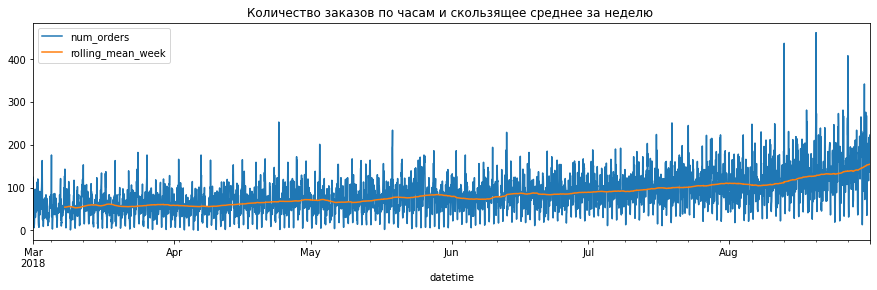

In [9]:
data['rolling_mean_week'] = data.rolling(168).mean()
data.plot(figsize = (15,4), title = 'Количество заказов по часам и скользящее среднее за неделю ')
data = data.drop('rolling_mean_week', axis=1)

Так как ближе к концу графика мы видим небольшой восходящий тренд, то проверим наш временной ряд на стационарность при помощи обобщенного теста Дикки-Фуллера:

In [10]:
from statsmodels.tsa.stattools import adfuller

st_test = adfuller(data['num_orders'], regression='ctt')
print('adf:', st_test[0])
print('p-value', st_test[1])
print('critical values:', st_test[4])
if st_test[0] > st_test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf: -10.891452237749158
p-value 4.0549397892403547e-17
critical values: {'1%': -4.373775161444573, '5%': -3.8337377543683258, '10%': -3.554095038926073}
единичных корней нет, ряд стационарен


По результатам теста наш временной ряд стационарен.

Для того, чтобы лучше проанализировать данные, воспользуемся функцией `seasonal_decompose()` из модуля `tsa.seasonal` библиотеки `statsmodels`. С помощью нее мы разложим временной ряд на три составляющие: тренд, сезонность и остаток:

In [11]:
decomposed = seasonal_decompose(data)

Выведем графики тренда, сезонности и остатка:

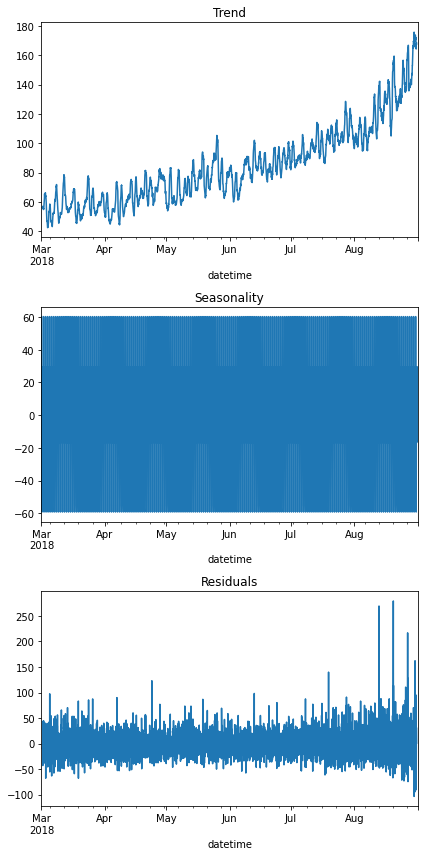

In [12]:
plt.figure(figsize=(6, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Что касается тренда, то из графика видно, что общее количество заказов такси увеличивается. Остатки (Residiuals) необъяснимы. А сезонность разберем подробнее. Для этого выведем ее отдельно для отрезка в 15 дней. Возьмем  период с 1 по 15 марта:

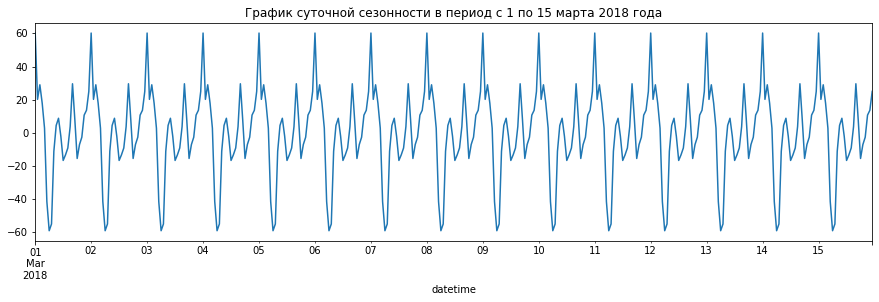

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(figsize = (15,4), title='График суточной сезонности в период с 1 по 15 марта 2018 года')
plt.show()

Как видим, для графика сезонности характерно ежедневное наличие 3 пиков. Так как мы исследуем изменение количества заказов такси по часам, то выведем график сезонности подробнее, а именно для периода в 2 дня - с 1 по 2 марта:

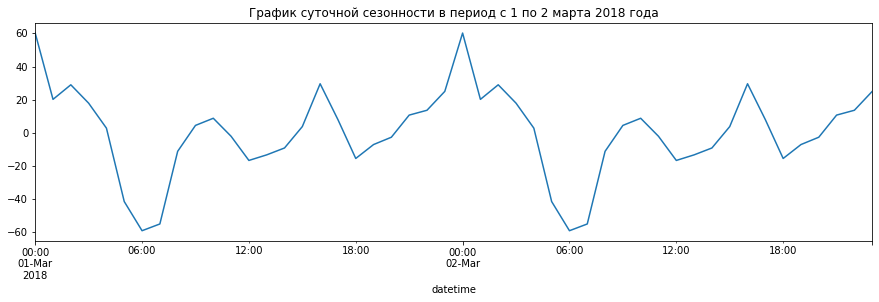

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize = (15,4), title='График суточной сезонности в период с 1 по 2 марта 2018 года')
plt.show()

Исходя из графика можно сделать следующие выводы:
1) Абсолютный минимум заказов в 6 утра

2) С 8 до 10 утра наблюдается утренний пик (возможная причина: люди вызывают такси, чтобы не ехать с чемоданами в общественном транспорте в час-пик )

3) Второй пик приходится на 15-17 часов (аналогично предыдущему пункту)

4) Третий пик наблюдается в вечернее время с 22 до 01 часов. Это можно объяснить тем, что, вероятно, люди  не могут воспользоваться общественным транспортом (уже не ходит в это время), поэтому вызывают такси.

Теперь исследуем недельную сезонность. Для этого ресемплируем датасет по дням, а затем выведем график сезонности в период с 1 по 31 марта 2018 года

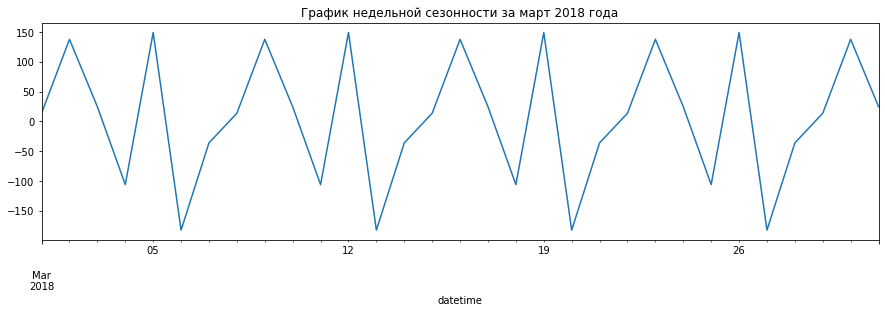

In [15]:
decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize = (15,4), title='График недельной сезонности за март 2018 года')
plt.show()

Исходя из графика можно сделать следующие выводы:

* Есть четко выраженная недельная сезонность.

* Минимум заказов приходится на вторники и воскресенья

* Максимальное количество заказов происходит в понедельники и пятницы

## Обучение

В нашей таблице всего 1 столбец - количество заказов. Для того, чтобы обучить модели нам надо создать дополнительные признаки. Для этого напишем функцию make_features().

* Календарные признаки. Так как в нашей таблице содержатся только данные за пол года, то выделим следующие признаки: день недели, часы

* Предыдущие значения. Cоздадим столбцы с отстающими значениями с максимальным размером отставания в 5 часов.

* Cкользящее среднее. Ранее мы выяснили, что пики заказов приходятся на промежутки по 2-4 часа. Поэтому зададим ширину окна в 3 часа. Помимо этого создадим скользящее среднее по дням (24 часа) и за 3 дня, так как ранее мы выявили недельную сезонность.

На вход функцию make_features() будет принимать последовательно датасет, размер максимального отставания, ширину окна для скользящего среднего.


In [16]:
def make_features(data, max_lag, rolling_mean_size):

    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['rolling_mean_2'] = data['num_orders'].shift().rolling(24).mean()#скользящее среднее за сутки
    data['rolling_mean_3'] = data['num_orders'].shift().rolling(72).mean()#скользящее среднее за 3 суток


make_features(data, 5, 3)


Удалим строки, содержащие пропуски:

In [17]:
data = data.dropna()

В качестве дополнительного признака создадим столбец, который будет содержать разницу между количеством заказов в предыдущий и предшествующий тому часы:

In [18]:
data['lag_1-lag_2'] = data['lag_1']-data['lag_2']

Прежде чем обучать модели нам надо разбить датасет на обучающую и тестовую выборки. При этом размер тестовой выборки должен составлять 10% от всей. Целевой признак - столбец 'num_orders':

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### Линейная регрессия

Первой обучим модель линейной регрессии.

Для подбора параметров будем использовать GridSearchCV, а для кросс-валидации на временных рядах TimeSeriesSplit.
В качестве параметров зададим normalize и fit_intercept:

In [20]:
parametrs = {'normalize': [True, False],
            'fit_intercept': [True, False]}

             
linear = LinearRegression()
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(linear, parametrs, cv=tscv, scoring= 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

{'fit_intercept': False, 'normalize': True}

Выведем лучшее значение RMSE c помощью атрибута best_score_:

In [21]:
grid.best_score_

-31.04345413206618

Таким образом минимум RMSE равный 31.04 достигается при normalize=True и fit_intercept=False.

### Случайный лес в регрессии

Далее обучим модель случайного леса в регрессии - RandomForestRegressor(). В качестве изменяемого гиперпараметра выберем n_estimators. Диапазон значений - от 1 до 8 включительно:

In [22]:
parametrs = {'n_estimators': range(1, 10)}

             
random_forest = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(random_forest, parametrs, cv=tscv, scoring= 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_

{'n_estimators': 9}

In [23]:
grid.best_score_

-25.091856831404776

Как видим, минимум RMSE равный 25.09 достигается при n_estimators=9.

### Catboost

Далее перейдем к модели градиентного бустинга из библиотеки Catboost - CatBoostRegressor(). Исследуем параметры iterations (максимальное количество деревьев, которые могут быть построены при решении) и  depth (глубина дерева):

In [24]:
parametrs = {'depth': range(1, 10),
            'iterations': range(1,9) }

             
catboost = CatBoostRegressor(random_state=12345, learning_rate=1)
train_pool = Pool(features_train, target_train)
tscv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(catboost, parametrs, cv=tscv, scoring= 'neg_root_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_


0:	learn: 25.7547932	total: 46.4ms	remaining: 0us
0:	learn: 26.6653712	total: 361us	remaining: 0us
0:	learn: 26.7928867	total: 371us	remaining: 0us
0:	learn: 28.1671844	total: 364us	remaining: 0us
0:	learn: 28.4439756	total: 402us	remaining: 0us
0:	learn: 29.7588511	total: 471us	remaining: 0us
0:	learn: 30.1220968	total: 454us	remaining: 0us
0:	learn: 30.5683509	total: 562us	remaining: 0us
0:	learn: 31.0908160	total: 619us	remaining: 0us
0:	learn: 32.5215702	total: 544us	remaining: 0us
0:	learn: 25.7547932	total: 221us	remaining: 221us
1:	learn: 24.2737274	total: 535us	remaining: 0us
0:	learn: 26.6653712	total: 338us	remaining: 338us
1:	learn: 24.2959572	total: 799us	remaining: 0us
0:	learn: 26.7928867	total: 370us	remaining: 370us
1:	learn: 24.9772000	total: 842us	remaining: 0us
0:	learn: 28.1671844	total: 471us	remaining: 471us
1:	learn: 26.4566646	total: 944us	remaining: 0us
0:	learn: 28.4439756	total: 421us	remaining: 421us
1:	learn: 26.8980061	total: 935us	remaining: 0us
0:	learn:

{'depth': 4, 'iterations': 8}

In [25]:
grid.best_score_

-26.404168340672083

После перебора всех параметров видно, что минимум RMSE равный 26.40 достигается при depth=4, iterations=8.

Оформим результаты работы моделей в виде сравнительной таблицы:

In [26]:
cols = ['model', 'best_rmse_score']
model_data = [['LinearRegression', 31.04],
             ['RandomForestRegressor', 25.09],
             ['CatBoostRegressor', 26.40]]
model_comparison_table = pd.DataFrame(data= model_data, columns = cols)
model_comparison_table

,model,best_rmse_score
0,LinearRegression,31.04
1,RandomForestRegressor,25.09
2,CatBoostRegressor,26.40


Как видно из сравнительной таблицы, лучше всего работает модель случайного леса в регрессии (25.09), хуже всего - модель линейной регрессии (31.04).

## Тестирование

Протестируем модель случайного леса в регрессии с гиперпараметром n_estimators=9 на тестовой выборке:

In [27]:
random_forest = RandomForestRegressor(random_state=12345, n_estimators=9)
random_forest.fit(features_train, target_train)
predictions = random_forest.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
rmse

46.55408971805134

Как видим, метрика RMSE равна 46.55 на тестовой выборке. Это удовлетворяет первоначальным требованиям.

Для наглядной интерпретации результатов выведем график реальных и предсказанных заказов:

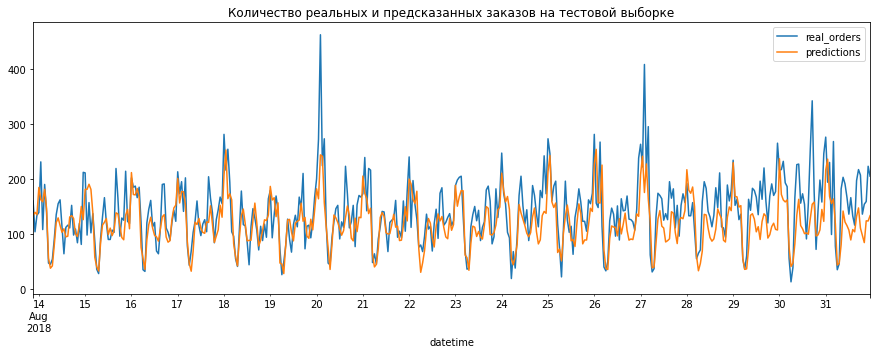

In [28]:
train_predictions = pd.DataFrame()
train_predictions['real_orders'] = target_test
train_predictions['predictions'] = predictions
train_predictions.plot(figsize=(15,5), title='Количество реальных и предсказанных заказов на тестовой выборке')
plt.show()

### Общий вывод

В этой работе:

* Выявили, что наш временной ряд является нестационарным

* Определили тренд - общее количество заказов такси увеличивается.

* Нашли часовую сезонность: 3 пика заказов приходятся на периоды с 8 до 10,  с 15 до 17, с 22 до 01 часов. При этом каждый день абсолютный минимум заказов приходится на время около 6 часов утра.

* Выявили недельную сезонность: минимум заказов приходится на вторники и воскресенья, максимум - на понедельники и пятницы.

* Создали дополнительные признаки: календарные (месяц, день, день недели, часы), предыдущие значения с  размером отставания в 1-5 часов, скользящие средние с шириной окна в 3 часа, по дням (24 часа) и за 3 дня. Дополнительно создали столбец, который содержит разницу между количеством заказов в предыдущий и предшествующий тому часы.

* Обучили три различные модели: линейной регрессии, случайного леса и градиентного бустинга из библиотеки CatBoost. 


Лучше всего на обучающей выборке справилась модель случайного леса в регрессии (25.09), хуже всего - модель линейной регрессии (31.04).

Лучшая модель (модель случайного леса в регрессии с  гиперпараметром n_estimators=9)  на тестовой выборке она показывает 
значение метрики RMSE 46.55.